In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from keras.layers import Dense, Input
from keras.models import Model

import omnifold6b as of

import tensorflow as tf


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.13.1





## Set model and resolution parameters

In [3]:
ndim = 2

##-------------

train_mu = [ 0.0, 1.0 ]



train_rho = [ [-0.6] ]






train_sig = [ 1.0, 1.5 ]


##-------------


true_mu = [ 0.2, 0.8 ]






true_rho  = [ [-0.6] ]



true_sig = [ 0.9, 1.3 ]



#--- nominal
resolution = [ 0.5, 0.8  ]

#--- poor
#resolution = [ 1.0, 1.6  ]






train_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n Train covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            train_cov[i][j] = train_sig[i] * train_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, train_cov[i][j]))
        else :
            k = ndim - j - 1
            train_cov[i][j] = train_sig[i] * train_sig[j] * train_rho[i][k]
            train_cov[j][i] = train_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, train_sig[i], train_sig[j], train_rho[i][k], train_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                




ngen_train =   200000
ngen_true =    100000




of_niter = 5

learning_rate_setval = 0.0005


epochs_setval = 40

batch_size_setval = int( ngen_true )



output_dir = 'toy-study6b-2d-7b'

save_step2_model = True





 Train covariance:
   0,  0 : diagonal    1.0000
   0,  1 :              1.000 *    1.500 *   -0.600 =  -0.9000
   1,  1 : diagonal    2.2500



 True covariance:
   0,  0 : diagonal    0.8100
   0,  1 :              0.900 *    1.300 *   -0.600 =  -0.7020
   1,  1 : diagonal    1.6900


In [4]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [5]:
print("\n\n")
print("Train covariance determinant:  %f" % np.linalg.det( train_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




Train covariance determinant:  1.440000
True covariance determinant:   0.876096





In [6]:
train_cov_inv = np.linalg.inv( train_cov )

In [7]:
train_cov_inv_test = np.matmul( train_cov, train_cov_inv )

In [8]:
print("\n\n")
print(" Train covariance")
print( train_cov )
print("\n Train covariance inverse")
print( train_cov_inv )
print("\n Train covariance inverse test")
print(train_cov_inv_test)
print("\n\n")




 Train covariance
[[ 1.   -0.9 ]
 [-0.9   2.25]]

 Train covariance inverse
[[1.5625     0.625     ]
 [0.625      0.69444444]]

 Train covariance inverse test
[[ 1.00000000e+00 -3.82410153e-17]
 [-5.55111512e-17  1.00000000e+00]]





In [9]:
true_cov_inv = np.linalg.inv( true_cov )

In [10]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [11]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[ 0.81  -0.702]
 [-0.702  1.69 ]]

 True covariance inverse
[[1.92901235 0.80128205]
 [0.80128205 0.92455621]]

 True covariance inverse test
[[ 1.00000000e+00  3.80221824e-17]
 [-5.90695584e-17  1.00000000e+00]]





## Generate samples, save events and config

In [12]:


train_pts = np.random.multivariate_normal(train_mu, train_cov, size=ngen_train)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

train_det_pts = np.random.normal( train_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights


In [13]:
with open( '%s/train-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, train_pts)
    np.save(f, train_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [14]:
with open( '%s/config-pars.npy' % output_dir , 'wb' ) as f :
    np.save( f, train_mu )
    np.save( f, train_rho )
    np.save( f, train_sig )
    np.save( f, true_mu )
    np.save( f, true_rho )
    np.save( f, true_sig )
    np.save( f, resolution )
    np.save( f, train_cov )
    np.save( f, true_cov )

In [15]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_train %d\n' % ngen_train )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )


config_file.write('\n\n')
config_file.write('train_mu : %s\n' % str(train_mu))
config_file.write('train_rho : %s\n' % str(train_rho))
config_file.write('train_sig : %s\n' % str(train_sig))
config_file.write('train_cov : %s\n' % str(train_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : toy-study6b-2d-7b/config.txt

2024-03-13 12:53:05.218582

ngen_train 200000
ngen_true  100000
of_niter   5
ndim       2
learning_rate_setval  0.000500
epochs_setval  40
batch_size_setval  100000


train_mu : [0.0, 1.0]
train_rho : [[-0.6]]
train_sig : [1.0, 1.5]
train_cov : [[ 1.   -0.9 ]
 [-0.9   2.25]]


true_mu : [0.2, 0.8]
true_rho : [[-0.6]]
true_sig : [0.9, 1.3]
true_cov : [[ 0.81  -0.702]
 [-0.702  1.69 ]]


resolution : [0.5, 0.8]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

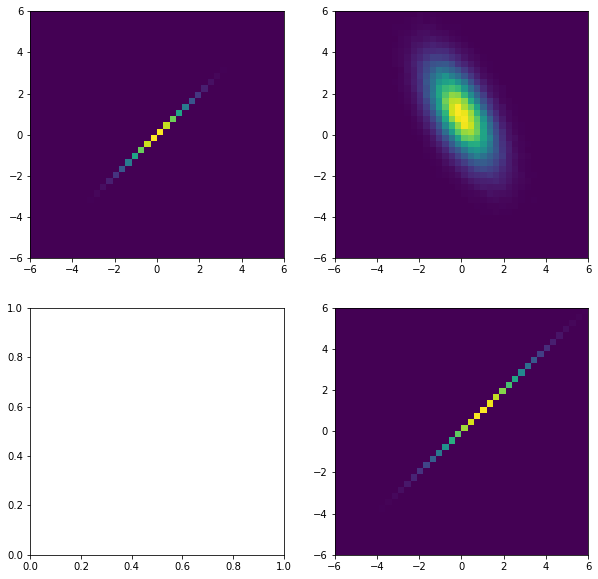

In [16]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( train_pts[:,i], train_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

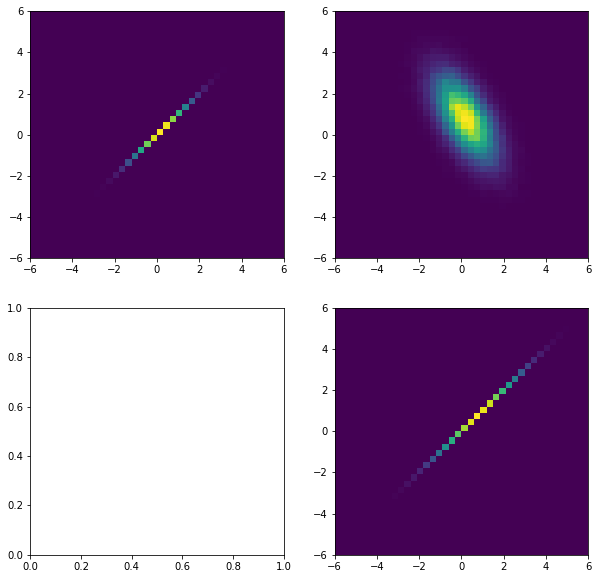

In [17]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        ax[i][j].hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

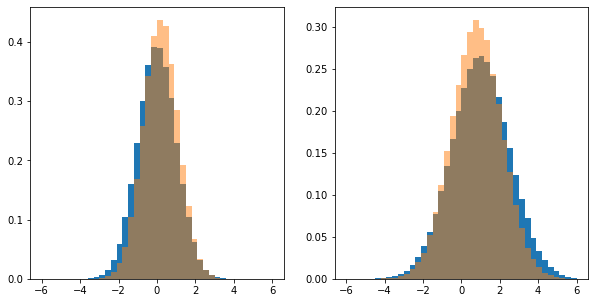

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        ax[i].hist( train_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        ax[i].hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [19]:
train_pts_minus_train_mu = train_pts - train_mu
print(train_pts_minus_train_mu)

[[-0.28636895 -0.94645376]
 [ 0.93121483 -1.12421946]
 [-0.5035193   0.81170118]
 ...
 [ 0.63892154 -0.06924266]
 [ 0.6169583  -0.46985463]
 [ 0.64268612 -1.96425373]]


In [20]:
train_pts_minus_true_mu = train_pts - true_mu
print(train_pts_minus_true_mu)

[[-0.48636895 -0.74645376]
 [ 0.73121483 -0.92421946]
 [-0.7035193   1.01170118]
 ...
 [ 0.43892154  0.13075734]
 [ 0.4169583  -0.26985463]
 [ 0.44268612 -1.76425373]]


In [21]:
true_cov_inv_times_v = np.tensordot( true_cov_inv, train_pts_minus_true_mu.T, axes=(1,0) )

In [22]:
v_times_true_cov_inv_times_v =  np.sum( train_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)

In [23]:
train_cov_inv_times_v = np.tensordot( train_cov_inv, train_pts_minus_train_mu.T, axes=(1,0) )

In [24]:
v_times_train_cov_inv_times_v =  np.sum( train_pts_minus_train_mu.T * train_cov_inv_times_v, axis=0)

In [25]:
exp_v_times_train_cov_inv_times_v = np.exp( -0.5 * v_times_train_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )

In [26]:
true_cov_det = np.linalg.det( true_cov )
train_cov_det = np.linalg.det( train_cov )

In [27]:
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )


 norm2_true : 8.646721



In [28]:
norm2_train = np.power( 3.14159265, ndim) * train_cov_det
print("\n norm2_train : %f\n" % norm2_train )


 norm2_train : 14.212230



In [29]:
pdf_train = exp_v_times_train_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)

[0.15388506 0.16711745 0.22347595 ... 0.19790102 0.2187331  0.11075563]


In [30]:
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)

[0.15641636 0.2351226  0.23251316 ... 0.26759105 0.30428863 0.1248455 ]


In [31]:
pdf_ratio = pdf_true / pdf_train

In [32]:
sample_sf = (1.*len(true_pts))/(1.*len(train_pts))
print('\n sample_sf = %f' % sample_sf )


 sample_sf = 0.500000


In [33]:
calc_weight = pdf_ratio

In [34]:
calc_weight_scaled = sample_sf * pdf_ratio

In [35]:
with open( '%s/analytic-weights.npy' % output_dir, 'wb') as f :
    np.save(f, calc_weight_scaled)

## Set up NN model for OmniFold

In [36]:
inputs = Input((ndim, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

## Package the training data for OmniFold

In [37]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

## Run OmniFold

In [38]:
%%time


verbose = True






of_return_dict = of.omnifold6b( 
    train_both, true_det_pts, of_niter, model, verbose, 
    batch_size_setval, learning_rate_setval, epochs_setval,
    save_step2_model, output_dir
)

of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold6b


  shape of theta0_S : (200000, 2)
  shape of theta_unknown_S : (100000, 2)
  shape of xvals_1 :  (300000, 2)



  shape of labels0 : (200000,)
  shape of labels_unknown : (100000,)
  shape of yvals_1 :  (300000,)



  shape of theta0_G : (200000, 2)
  shape of xvals_2 :  (400000, 2)
  shape of yvals_2 :  (400000,)

 batch size setval  100000
 learning rate setval  0.000500
 epochs setval  40




ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
             running pre-training, distinguish from self.
Epoch 1/5
3/3 [==============================] - 1s 5ms/step - loss: 0.6946 - accuracy: 0.4464
Epoch 2/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.3675
Epoch 3/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.6008
Epoch 4/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.6511
Epoch 5/5
3/3 [=========================

Epoch 52/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3644 - val_loss: 0.4558 - val_accuracy: 0.3644
Epoch 53/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3645 - val_loss: 0.4558 - val_accuracy: 0.3646
Epoch 54/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3647 - val_loss: 0.4558 - val_accuracy: 0.3649
Epoch 55/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3647 - val_loss: 0.4558 - val_accuracy: 0.3646
Epoch 56/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3646 - val_loss: 0.4558 - val_accuracy: 0.3642
Epoch 57/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3644 - val_loss: 0.4558 - val_accuracy: 0.3645
Epoch 58/80
3/3 [==============================] - 0s 13ms/step - loss: 0.4572 - accuracy: 0.3648 - val_loss: 0.4558 - val_accuracy: 0.3644
Epoch 59/80
3/3 [===

Epoch 26/80
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.4032 - val_loss: 0.6853 - val_accuracy: 0.4025
Epoch 27/80
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.4029 - val_loss: 0.6853 - val_accuracy: 0.4021
Epoch 28/80
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.4026 - val_loss: 0.6853 - val_accuracy: 0.4018
Epoch 29/80
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.4024 - val_loss: 0.6853 - val_accuracy: 0.4016
Epoch 30/80
3/3 [==============================] - 0s 12ms/step - loss: 0.6854 - accuracy: 0.4022 - val_loss: 0.6853 - val_accuracy: 0.4014
Epoch 31/80
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.4020 - val_loss: 0.6853 - val_accuracy: 0.4013
Epoch 32/80
3/3 [==============================] - 0s 13ms/step - loss: 0.6854 - accuracy: 0.4019 - val_loss: 0.6853 - val_accuracy: 0.4011
Epoch 33/80
3/3 [===

INFO:tensorflow:Assets written to: toy-study6b-2d-7b/of-step2-iter00-model/assets



ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.08166206 1.23338342 0.96434993 ... 1.22854865 1.2258625  1.13895762]
             running pre-training, distinguish from self.
Epoch 1/5
3/3 [==============================] - 1s 3ms/step - loss: 0.7009 - accuracy: 0.5383
Epoch 2/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.6100
Epoch 3/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.6578
Epoch 4/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.6705
Epoch 5/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.6538
             done pretraining.
Epoch 1/40
3/3 [==============================] - 0s 52ms/step - loss: 0.4618 - accuracy: 0.3490 - val_loss: 0.4621 - val_accuracy: 0.3509
Epoch 2/40
3/3 [==============================] - 0s 13ms/step - loss: 0.4617 - accuracy: 0.3516 - val_loss: 0.4621 - val_accuracy: 0.3527
Epoch 3/40
3/

Epoch 10/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.2498 - val_loss: 0.6922 - val_accuracy: 0.2507
Epoch 11/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.2498 - val_loss: 0.6922 - val_accuracy: 0.2508
Epoch 12/40
3/3 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.2497 - val_loss: 0.6922 - val_accuracy: 0.2509
Epoch 13/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.2497 - val_loss: 0.6922 - val_accuracy: 0.2508
Epoch 14/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.2497 - val_loss: 0.6922 - val_accuracy: 0.2509
Epoch 15/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6924 - accuracy: 0.2497 - val_loss: 0.6922 - val_accuracy: 0.2510
Epoch 16/40
3/3 [==============================] - 0s 12ms/step - loss: 0.6924 - accuracy: 0.2497 - val_loss: 0.6922 - val_accuracy: 0.2509
Epoch 17/40
3/3 [===

INFO:tensorflow:Assets written to: toy-study6b-2d-7b/of-step2-iter01-model/assets



ITERATION: 3

   -- ITERATION 3  STEP 1

 weights_push at the beginning
[1.06658546 1.3035984  0.97346242 ... 1.31522564 1.29522335 1.14486638]
             running pre-training, distinguish from self.
Epoch 1/5
3/3 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.5356
Epoch 2/5
3/3 [==============================] - 0s 3ms/step - loss: 0.6936 - accuracy: 0.6563
Epoch 3/5
3/3 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.6427
Epoch 4/5
3/3 [==============================] - 0s 3ms/step - loss: 0.6934 - accuracy: 0.5533
Epoch 5/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5264
             done pretraining.
Epoch 1/40
3/3 [==============================] - 0s 52ms/step - loss: 0.4624 - accuracy: 0.3410 - val_loss: 0.4621 - val_accuracy: 0.3347
Epoch 2/40
3/3 [==============================] - 0s 14ms/step - loss: 0.4624 - accuracy: 0.3336 - val_loss: 0.4621 - val_accuracy: 0.3319
Epoch 3/40
3/

Epoch 10/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6929 - val_accuracy: 0.2502
Epoch 11/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6929 - val_accuracy: 0.2502
Epoch 12/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2500 - val_loss: 0.6929 - val_accuracy: 0.2502
Epoch 13/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2500 - val_loss: 0.6929 - val_accuracy: 0.2499
Epoch 14/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2500 - val_loss: 0.6929 - val_accuracy: 0.2500
Epoch 15/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2500 - val_loss: 0.6929 - val_accuracy: 0.2500
Epoch 16/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6937 - accuracy: 0.2499 - val_loss: 0.6929 - val_accuracy: 0.2502
Epoch 17/40
3/3 [===

INFO:tensorflow:Assets written to: toy-study6b-2d-7b/of-step2-iter02-model/assets



ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[1.0378282  1.31784152 0.99243636 ... 1.35326219 1.32711908 1.12940048]
             running pre-training, distinguish from self.
Epoch 1/5
3/3 [==============================] - 1s 3ms/step - loss: 0.6934 - accuracy: 0.5485
Epoch 2/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5353
Epoch 3/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5435
Epoch 4/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.6087
Epoch 5/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4522
             done pretraining.
Epoch 1/40
3/3 [==============================] - 0s 52ms/step - loss: 0.4616 - accuracy: 0.3326 - val_loss: 0.4621 - val_accuracy: 0.3280
Epoch 2/40
3/3 [==============================] - 0s 13ms/step - loss: 0.4616 - accuracy: 0.3266 - val_loss: 0.4621 - val_accuracy: 0.3244
Epoch 3/40
3/

Epoch 10/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2501
Epoch 11/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2500
Epoch 12/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2501
Epoch 13/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2499
Epoch 14/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2499
Epoch 15/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2499
Epoch 16/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6930 - accuracy: 0.2500 - val_loss: 0.6935 - val_accuracy: 0.2499
Epoch 17/40
3/3 [===

INFO:tensorflow:Assets written to: toy-study6b-2d-7b/of-step2-iter03-model/assets



ITERATION: 5

   -- ITERATION 5  STEP 1

 weights_push at the beginning
[1.00643054 1.33606029 0.99999386 ... 1.37211825 1.33138317 1.1273026 ]
             running pre-training, distinguish from self.
Epoch 1/5
3/3 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5737
Epoch 2/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5361
Epoch 3/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5020
Epoch 4/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.6378
Epoch 5/5
3/3 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5741
             done pretraining.
Epoch 1/40
3/3 [==============================] - 0s 52ms/step - loss: 0.4619 - accuracy: 0.3436 - val_loss: 0.4622 - val_accuracy: 0.3458
Epoch 2/40
3/3 [==============================] - 0s 14ms/step - loss: 0.4619 - accuracy: 0.3452 - val_loss: 0.4622 - val_accuracy: 0.3446
Epoch 3/40
3/

Epoch 10/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.2501 - val_loss: 0.6932 - val_accuracy: 0.2494
Epoch 11/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6932 - val_accuracy: 0.2493
Epoch 12/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.2501 - val_loss: 0.6932 - val_accuracy: 0.2494
Epoch 13/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6932 - val_accuracy: 0.2494
Epoch 14/40
3/3 [==============================] - 0s 12ms/step - loss: 0.6936 - accuracy: 0.2500 - val_loss: 0.6932 - val_accuracy: 0.2494
Epoch 15/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6932 - val_accuracy: 0.2495
Epoch 16/40
3/3 [==============================] - 0s 13ms/step - loss: 0.6936 - accuracy: 0.2502 - val_loss: 0.6932 - val_accuracy: 0.2495
Epoch 17/40
3/3 [===

INFO:tensorflow:Assets written to: toy-study6b-2d-7b/of-step2-iter04-model/assets


CPU times: user 34.9 s, sys: 6.41 s, total: 41.3 s
Wall time: 29 s


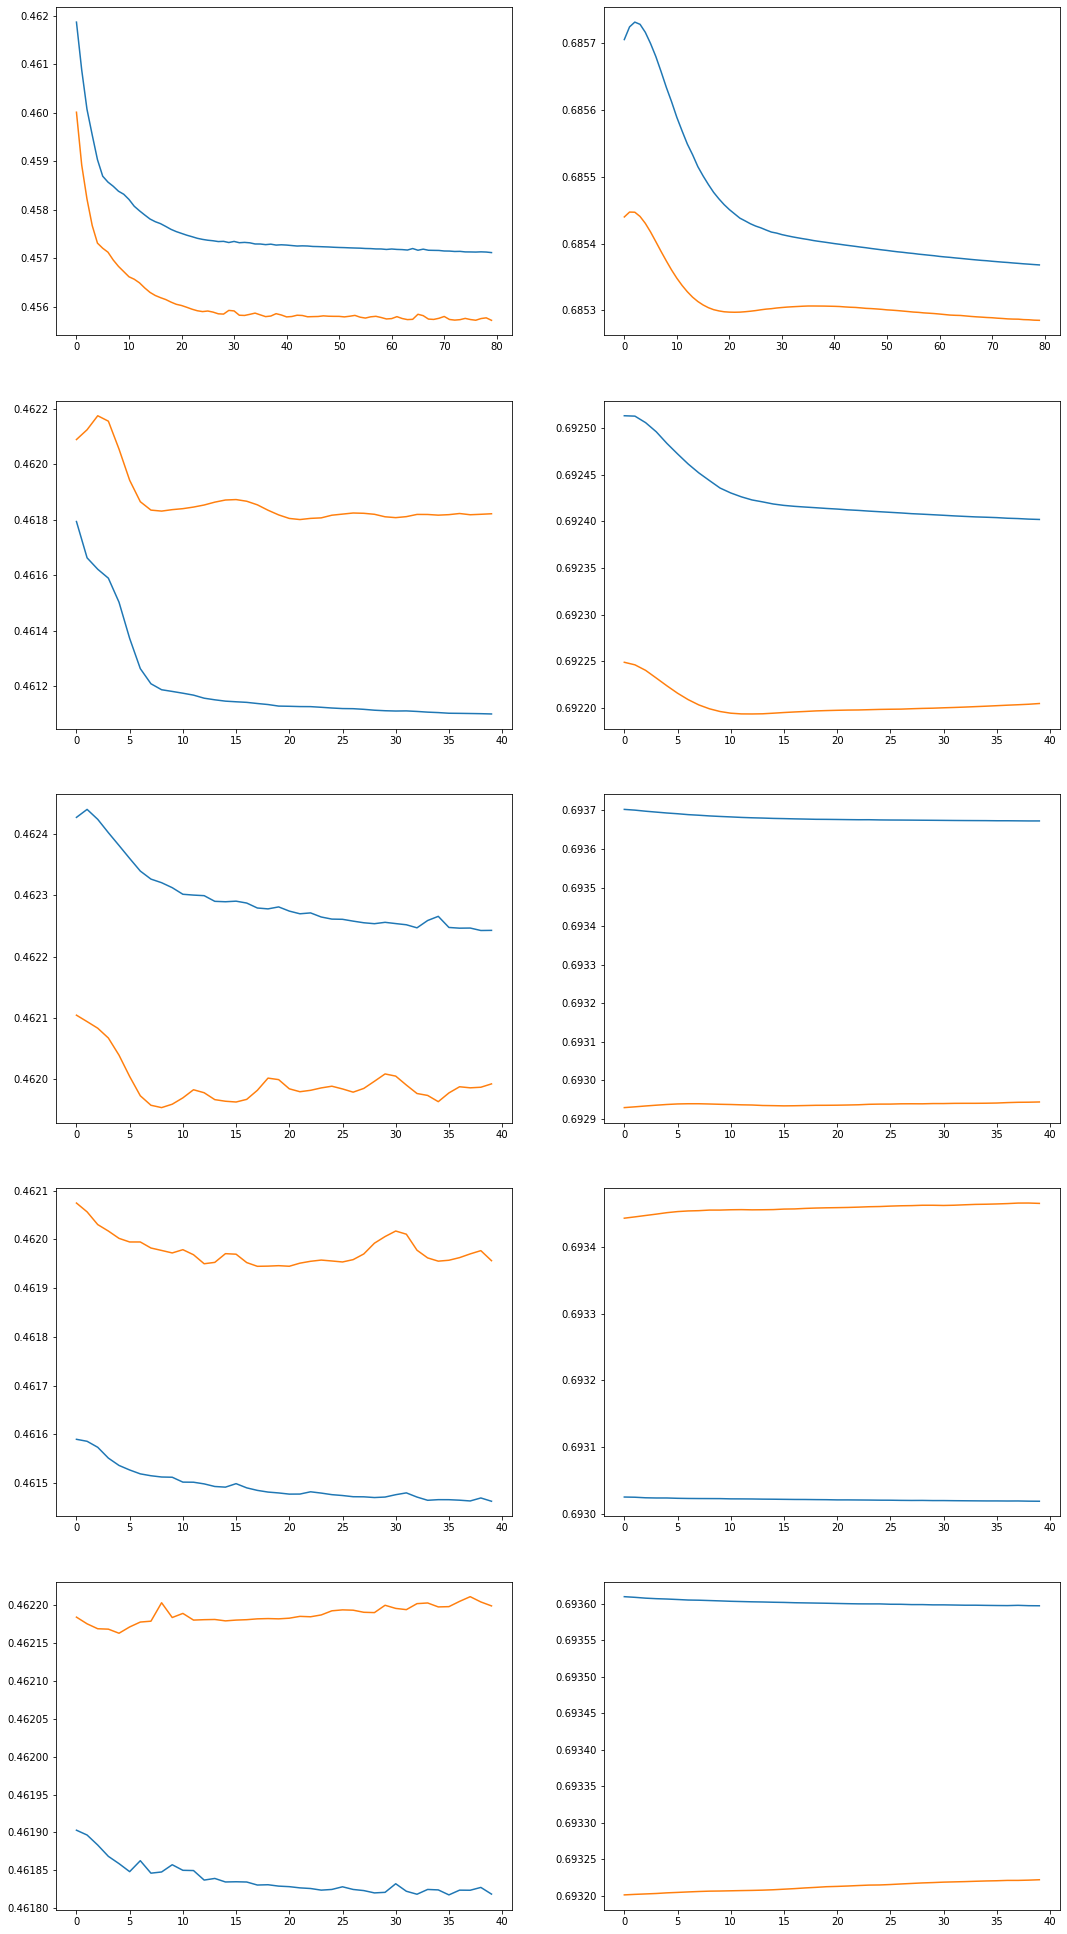

In [39]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['train-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['train-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

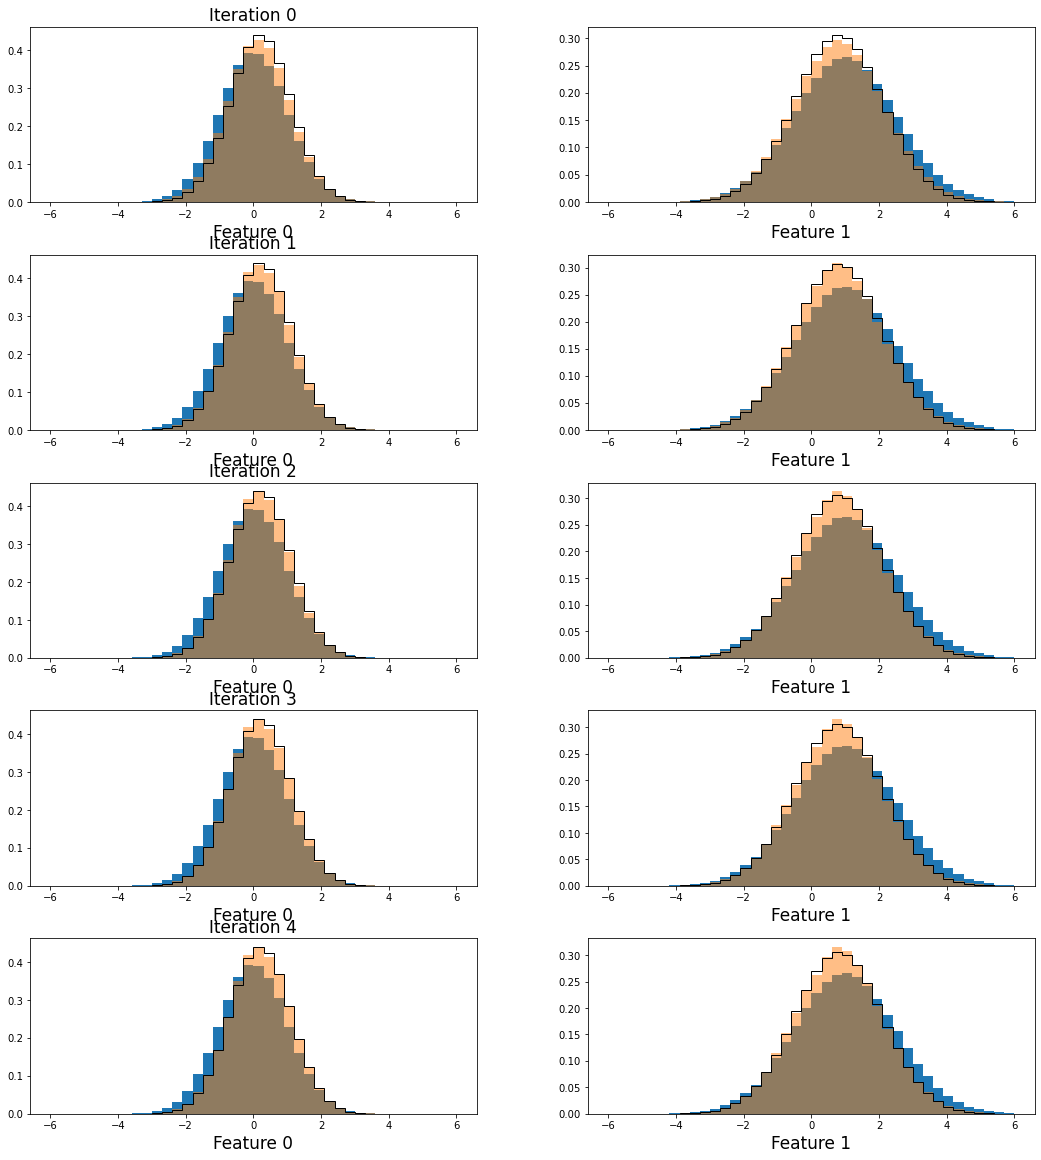

In [40]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            #hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

        
            hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            #hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
            hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [41]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

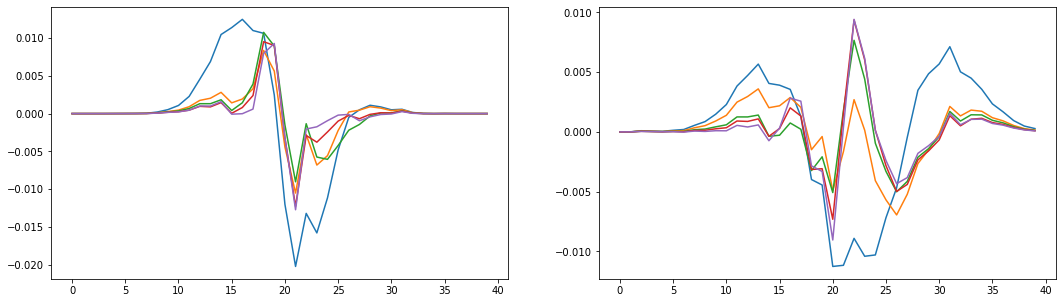

In [42]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

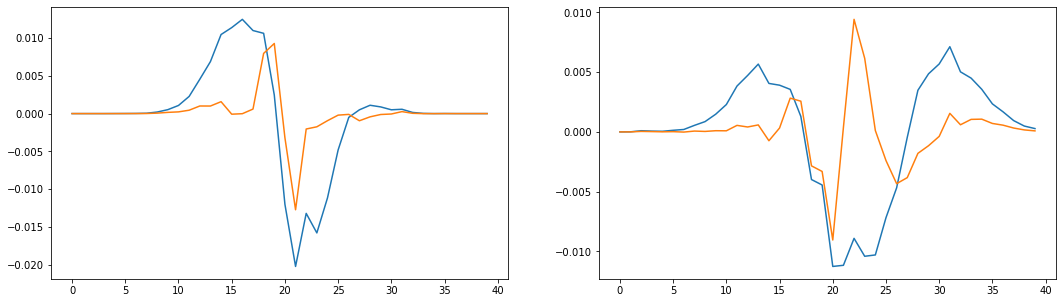

In [43]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

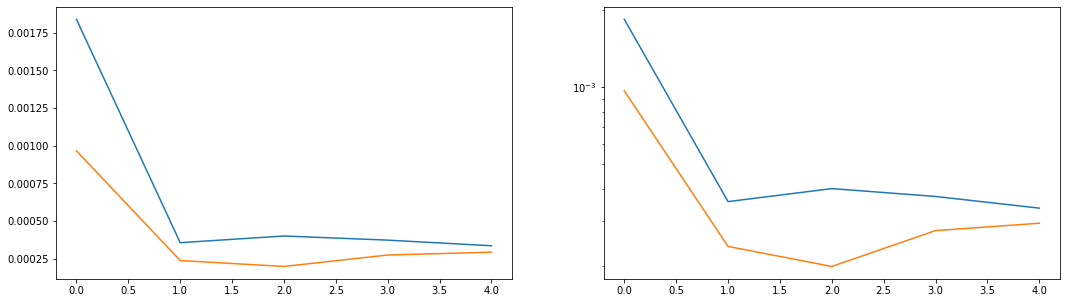

In [44]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

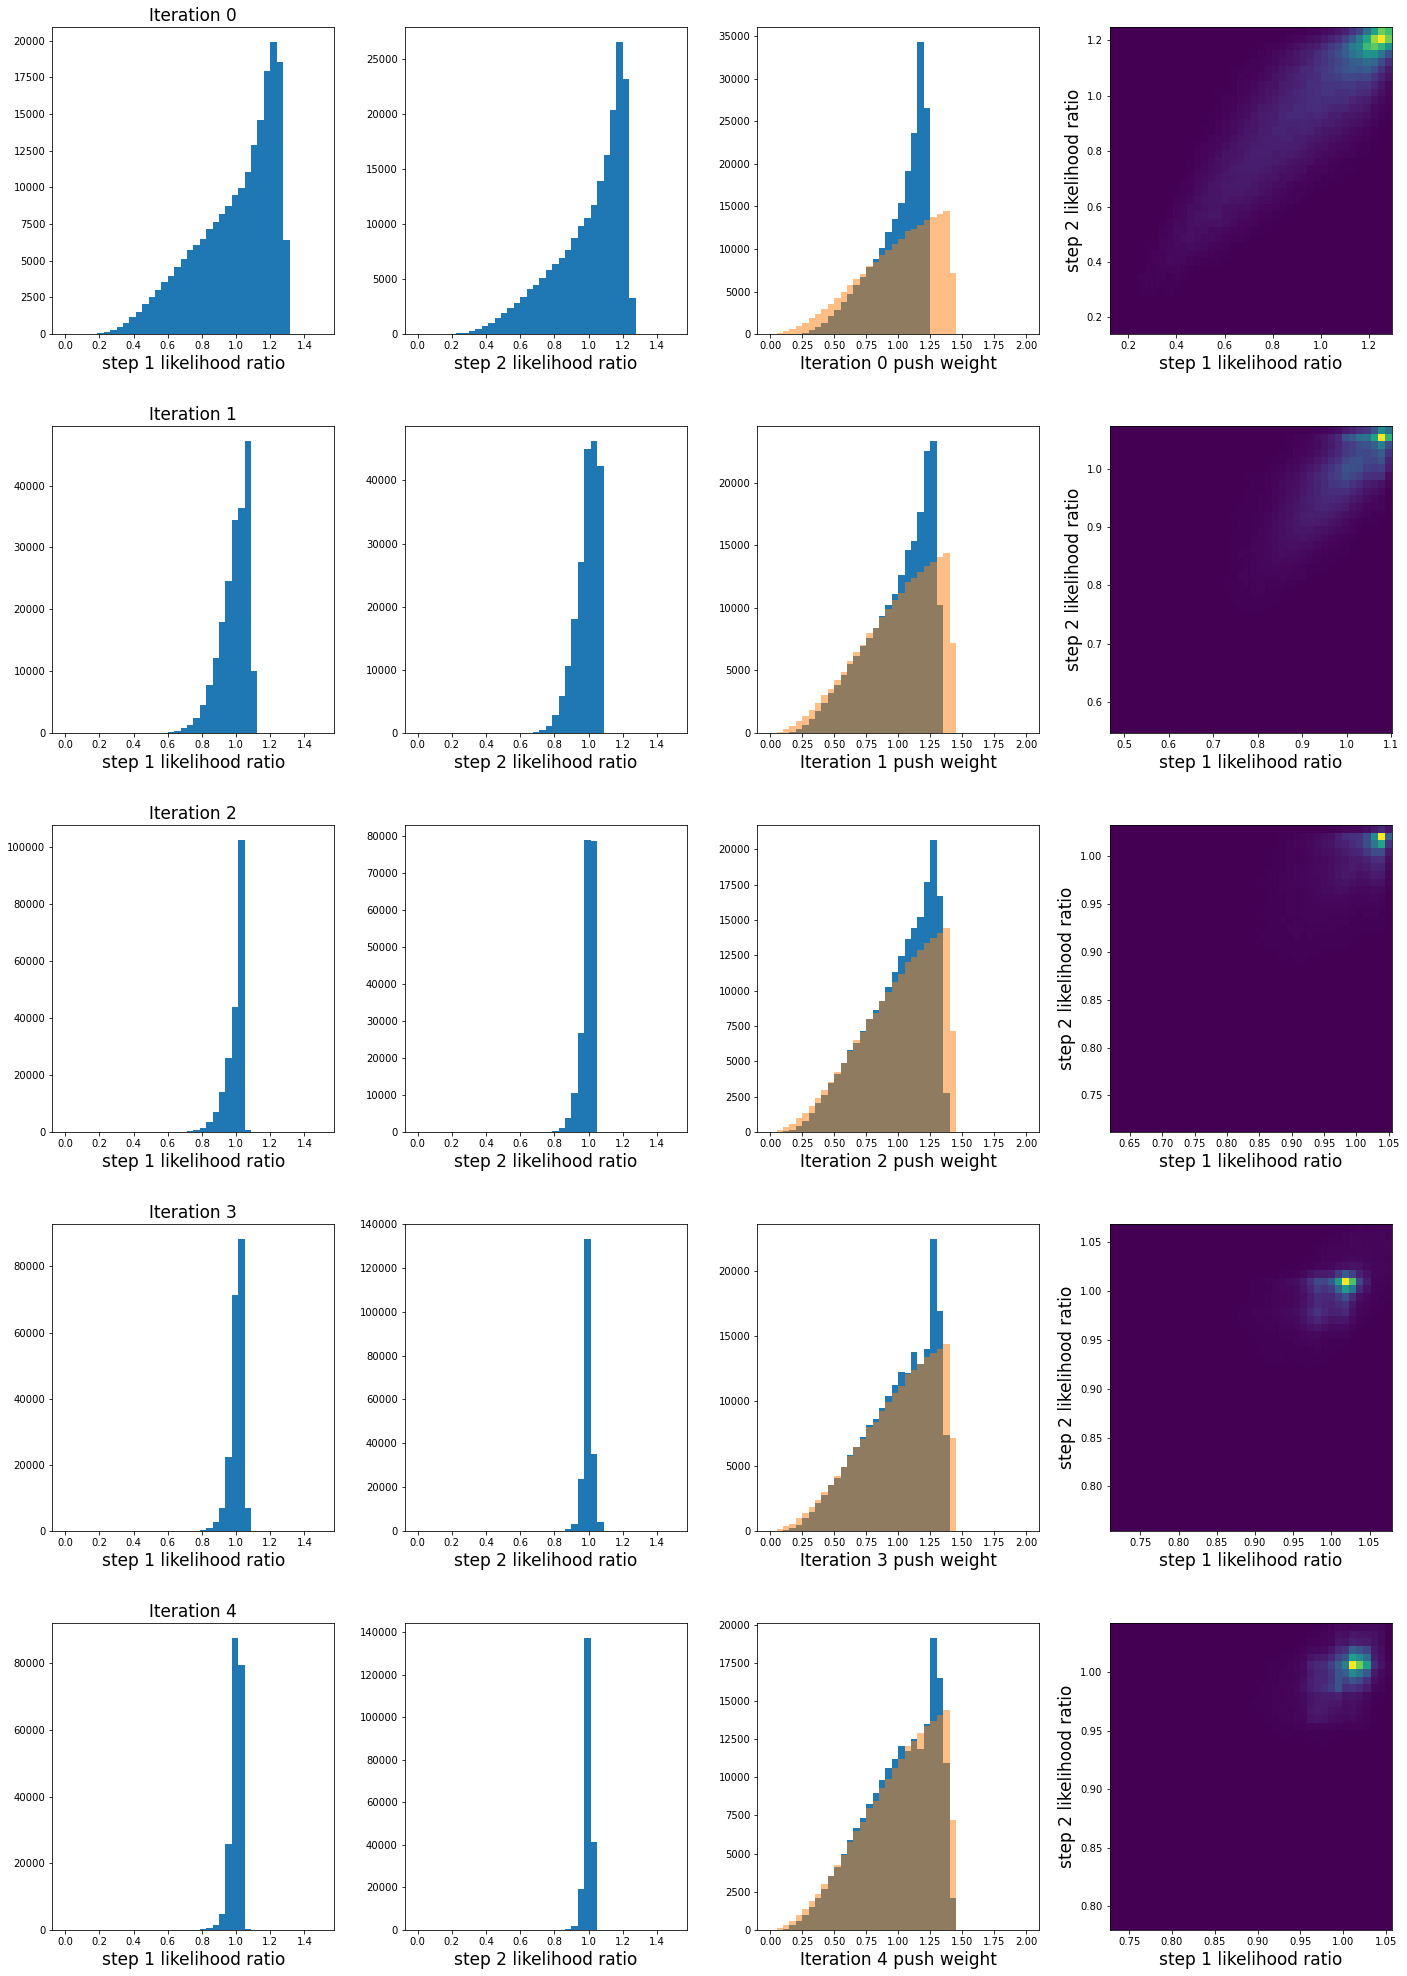

In [45]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

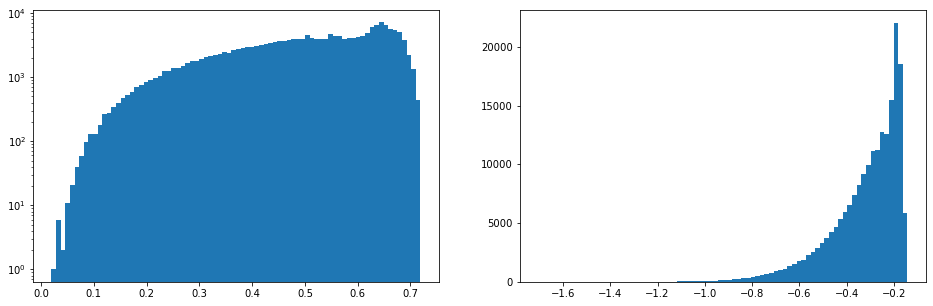

In [46]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

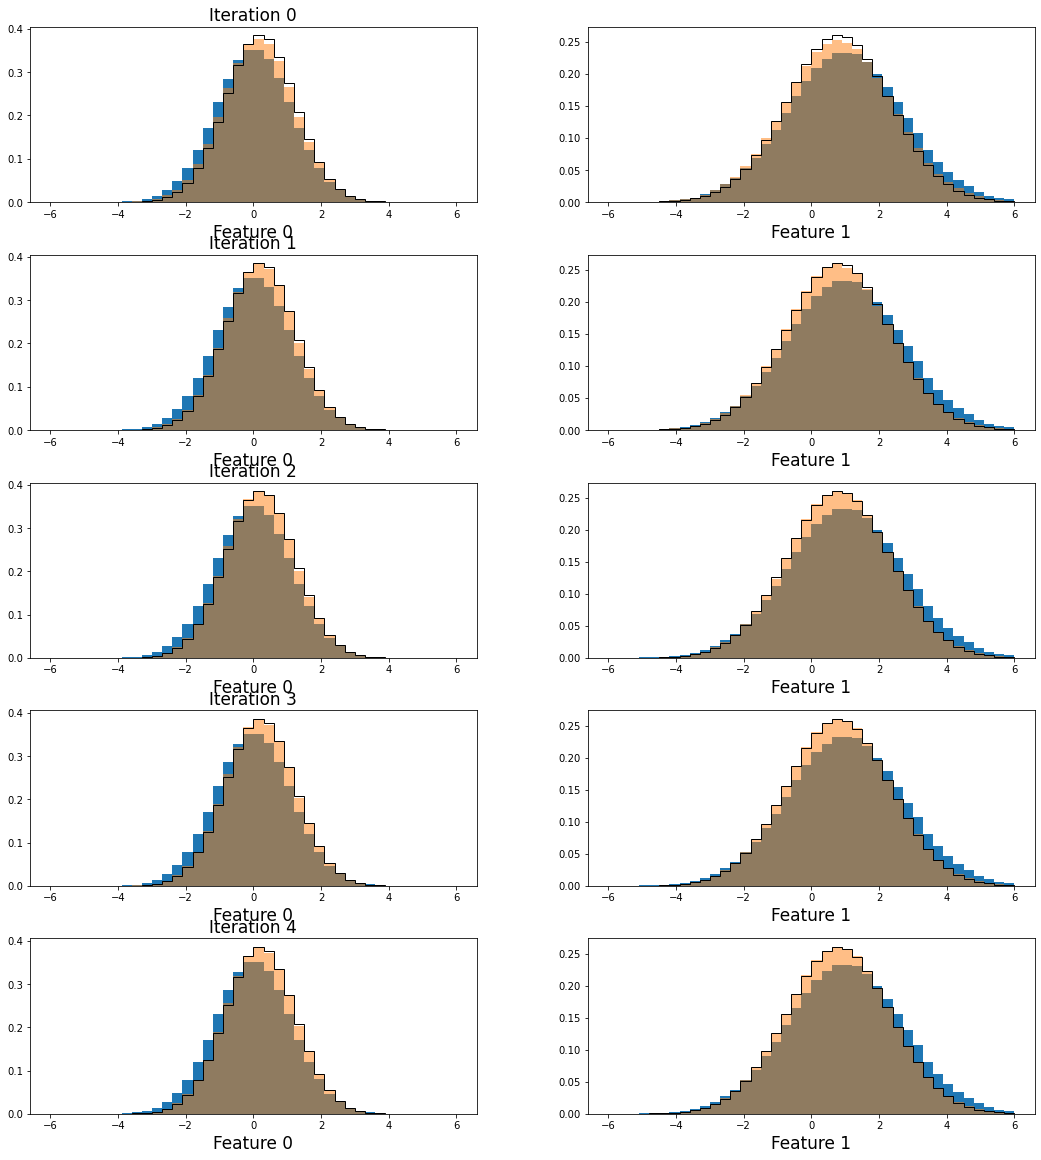

In [47]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            ax[ofi][di].hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            #det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = ax[ofi][di].hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            #det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
            det_hist_data_truth[ofi,di],_,_ =         ax[ofi][di].hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    
    #ax[ofi][0].legend(loc='best', fontsize=13)
    #ax[ofi][1].legend(loc='best', fontsize=13)
    
    
    ax[ofi][0].set_xlabel('Feature 0', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel('Feature 1', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [48]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

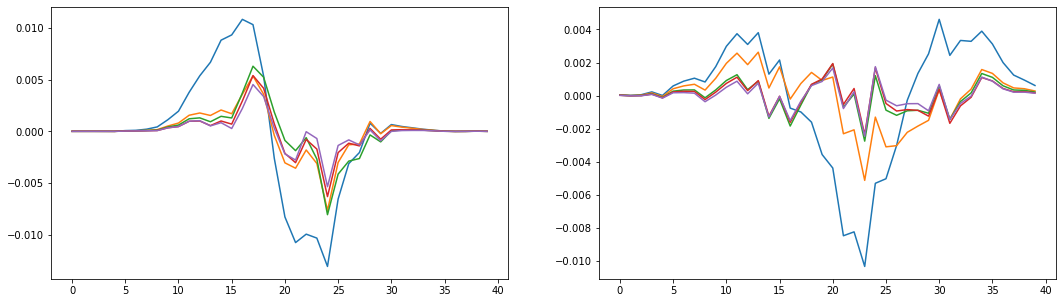

In [49]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

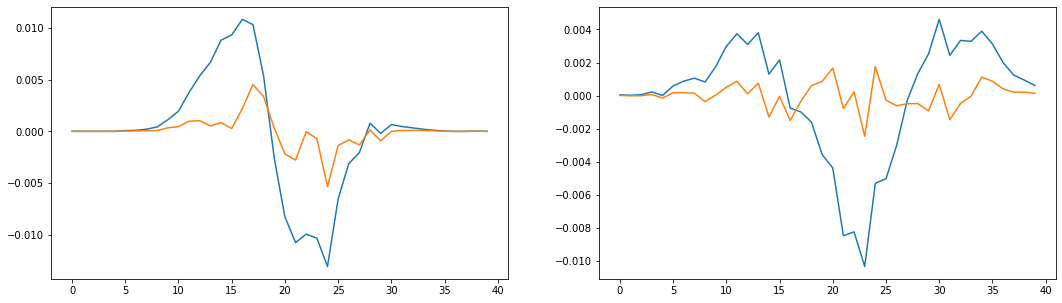

In [50]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    ax[di].plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

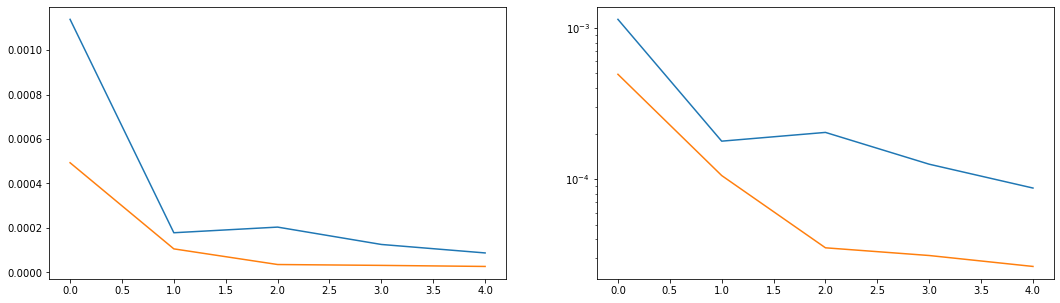

In [51]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [52]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.994  rms 0.233      step 2 mean  0.999  rms 0.206
  iter  1 : step 1 mean  0.989  rms 0.084      step 2 mean  0.990  rms 0.066
  iter  2 : step 1 mean  0.996  rms 0.052      step 2 mean  0.994  rms 0.034
  iter  3 : step 1 mean  1.002  rms 0.035      step 2 mean  0.998  rms 0.024
  iter  4 : step 1 mean  1.000  rms 0.028      step 2 mean  0.999  rms 0.019


<function matplotlib.pyplot.show(close=None, block=None)>

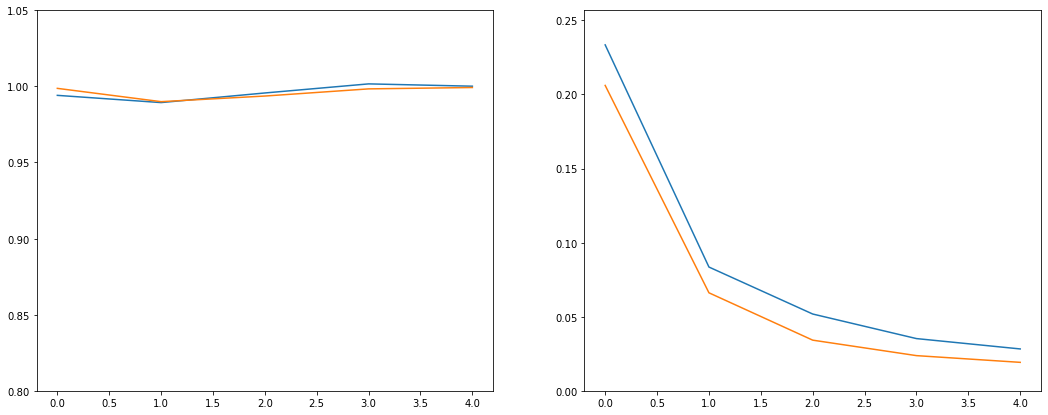

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

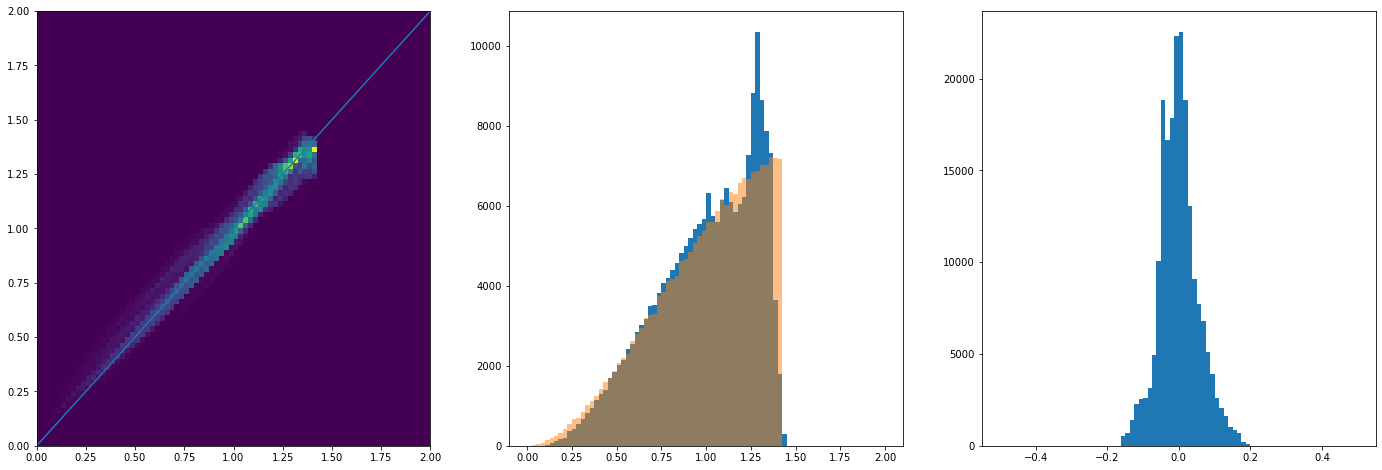

In [54]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [55]:

delta_weight_rms = np.sqrt( np.var( np.clip(final_push_weights-calc_weight,-0.5,0.5 ) ) )
print('\n\n Delta weight RMS:  %.5f\n\n' % delta_weight_rms )



 Delta weight RMS:  0.05421




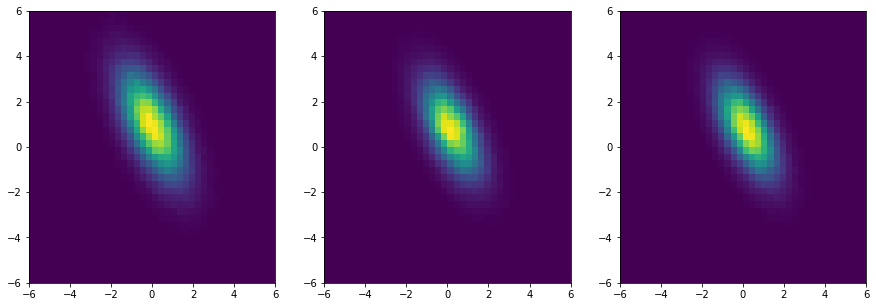

In [56]:

fig,ax = plt.subplots( 1, 3, figsize=(5*3,5))

xmin=-6
xmax=6
hbins=40


(unweighted_hist_vals, hist_binning, _, _) = ax[0].hist2d(train_pts[:,0], train_pts[:,1], bins=([hbins,hbins]), range=([xmin,xmax],[xmin,xmax]))

(  weighted_hist_vals, _, _, _) = ax[1].hist2d(train_pts[:,0], train_pts[:,1], weights=final_push_weights_scaled, bins=([hbins,hbins]), range=([xmin,xmax],[xmin,xmax]))

(  analytic_weighted_hist_vals, _, _, _) = ax[2].hist2d(train_pts[:,0], train_pts[:,1], weights=calc_weight_scaled, bins=([hbins,hbins]), range=([xmin,xmax],[xmin,xmax]))



In [57]:
unweighted_hist_vals = np.flip(np.transpose(unweighted_hist_vals), axis=0)
weighted_hist_vals = np.flip(np.transpose(weighted_hist_vals), axis=0)

analytic_weighted_hist_vals = np.flip(np.transpose(analytic_weighted_hist_vals), axis=0)

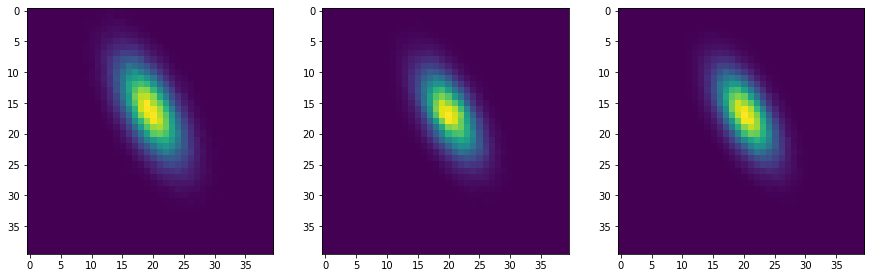

In [58]:
fig,ax = plt.subplots( 1, 3, figsize=(5*3,5))

ax[0].imshow( unweighted_hist_vals)
ax[1].imshow( weighted_hist_vals)
ax[2].imshow( analytic_weighted_hist_vals)

In [59]:
unweighted_hist_vals = np.clip( unweighted_hist_vals, 1e-16,1e20)

ave_weight = weighted_hist_vals / unweighted_hist_vals



analytic_ave_weight = analytic_weighted_hist_vals / unweighted_hist_vals

print(' max ave weight: %.2f' % np.max( ave_weight))

print(' max analytic weight:  %.2f' % np.max( analytic_ave_weight))


ave_weight = np.clip( ave_weight, 0., 1.1*np.max( analytic_ave_weight))


 max ave weight: 0.70
 max analytic weight:  0.71


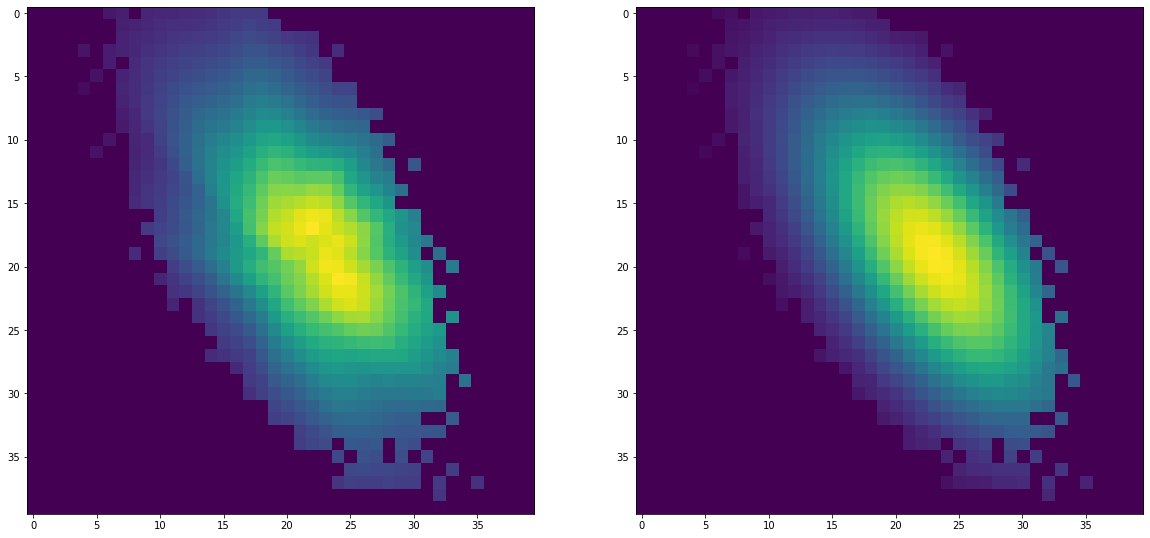

In [60]:
fig,ax = plt.subplots( 1, 2, figsize=(10*2,10))

ax[0].imshow( ave_weight )



ax[1].imshow( analytic_ave_weight )

In [65]:
ave_weight_diff = ave_weight-analytic_ave_weight


max_diff = 0.15

print( 'shape of diff : %s' % str(ave_weight_diff.shape))

ave_weight_diff = np.clip(ave_weight_diff, -1*max_diff, max_diff )


asize = ave_weight_diff.shape[0]

ave_weight_diff[0,0] = max_diff
ave_weight_diff[asize-1,asize-1] = -1*max_diff



shape of diff : (40, 40)


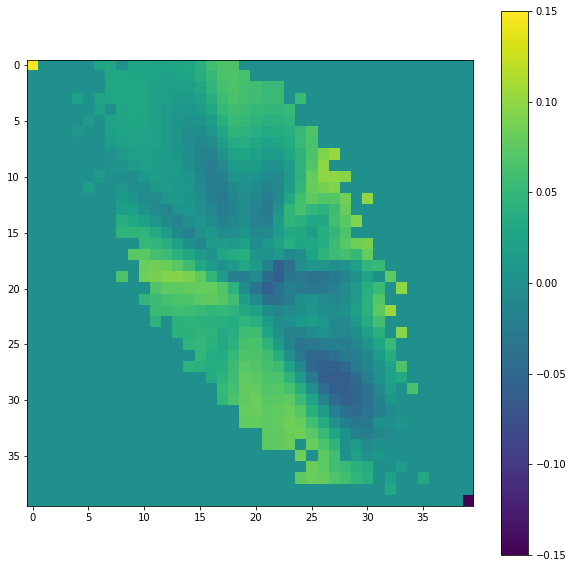

In [66]:
fig,ax = plt.subplots( 1, 1, figsize=(10,10))

im0 = ax.imshow( ave_weight_diff )
ax.figure.colorbar( im0, ax=ax )

